# A. Phase 1 : Préparation des données 



## I) Chargement des données brutes 

In [5]:
pip install pandas matplotlib

2479.69s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/duhameleve/Desktop/M2_SNS/M2SNS/Sante/Github/ProjetMottet/data/HommeCardio.csv"

data = pd.read_csv(file_path)

data.head()
timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # All remaining columns are sensor data

In [4]:
# Check the number of columns in the DataFrame to diagnose the issue
data.columns, len(data.columns)


(Index(['2024-10-06 15:39:03.097', '0.203125', '-0.687500', '-1.015625'], dtype='object'),
 4)

In [5]:

import pandas as pd
# Renommer les colonnes en tenant compte de leur nombre
data.columns = ['Temps', 'X', 'Y', 'Z']  # Ajoutez un nom pour chaque colonne présente

# Convertir la colonne 'Temps' en datetime si ce n'est pas déjà fait
data['Temps'] = pd.to_datetime(data['Temps'])

# Calculer le temps écoulé en secondes entre chaque ligne
data['Temps écoulé (s)'] = data['Temps'].diff().dt.total_seconds().fillna(0)

# Créer une nouvelle colonne pour le temps cumulé croissant
data['Temps cumulé (s)'] = data['Temps écoulé (s)'].cumsum()

# Afficher les premières lignes pour vérifier
data.head()


,Temps,X,Y,Z,Temps écoulé (s),Temps cumulé (s)
0,2024-10-06 15:39:03.100,0.234375,-0.703125,0.093750,0.000,0.000
1,2024-10-06 15:39:03.102,0.281250,-0.765625,0.093750,0.002,0.002
2,2024-10-06 15:39:03.105,0.281250,-0.765625,0.109375,0.003,0.005
3,2024-10-06 15:39:03.107,0.234375,-0.781250,0.109375,0.002,0.007
4,2024-10-06 15:39:03.110,0.234375,-0.781250,0.093750,0.003,0.010


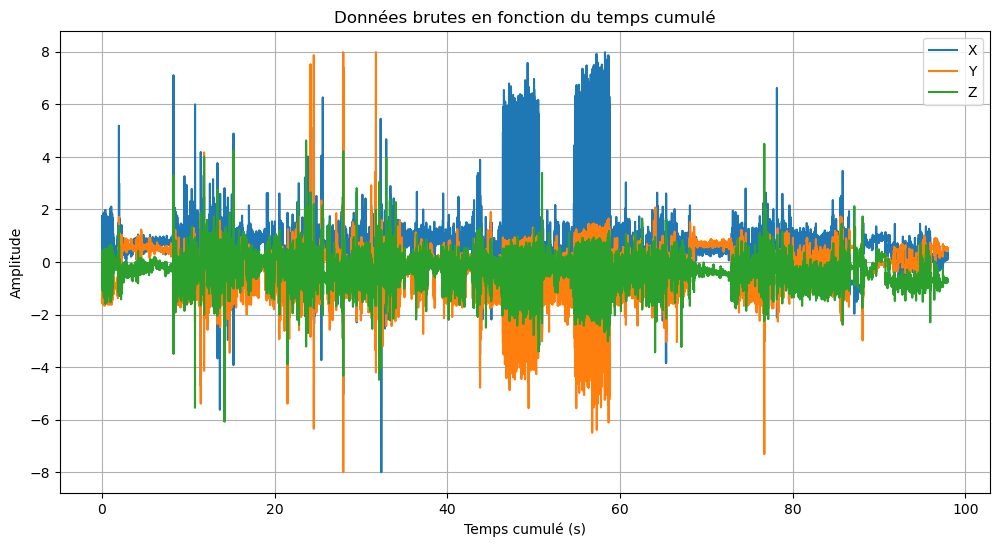

In [19]:
timestamp_column = data.columns[0]
signal_columns = data.columns[1:] 
# Assurez-vous que `signal_columns` est bien défini
signal_columns = ['X', 'Y', 'Z']  # Si vos colonnes de signal sont X, Y, Z
#
#  Calculate the sampling interval (in seconds)
sampling_interval = (pd.to_datetime(data[timestamp_column].iloc[1]) -
                     pd.to_datetime(data[timestamp_column].iloc[0])).total_seconds()

# Create a relative time axis (in minutes)
data['relative_time_minutes'] = data.index * sampling_interval / 60

# Tracer les données brutes
plt.figure(figsize=(12, 6))
for column in signal_columns:
    plt.plot(data['relative_time_minutes'], data[column], label=column)

plt.title("Données brutes en fonction du temps cumulé")
plt.xlabel("Temps cumulé (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()



## II) Zoom sur 10/90 min 

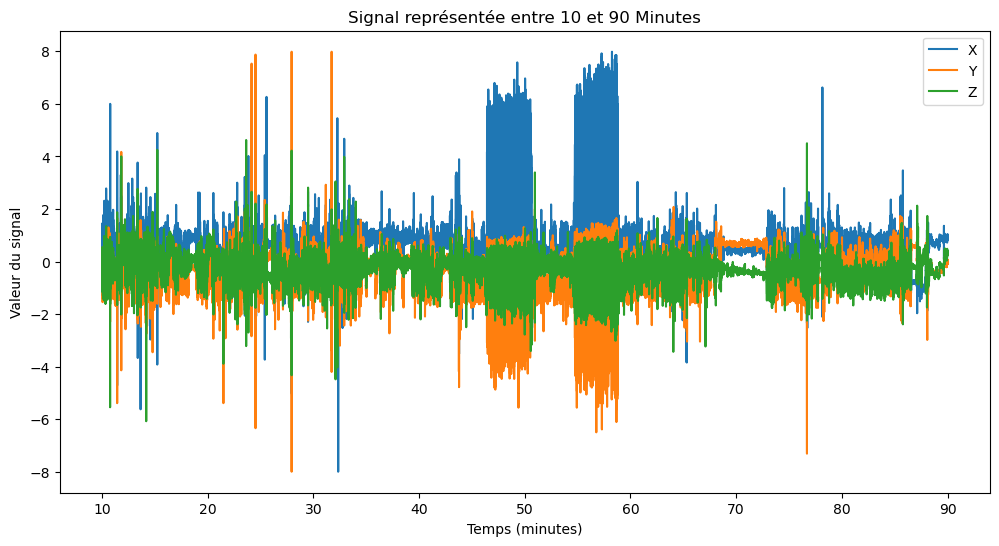

In [22]:
# Filter data to keep only rows where time is between 10 and 90 minutes
filtered_data = data[(data['relative_time_minutes'] >= 10) & (data['relative_time_minutes'] <= 90)]


# Plot the filtered signal
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    plt.plot(filtered_data['relative_time_minutes'], filtered_data[signal], label=signal)

plt.title("Signal représentée entre 10 et 90 Minutes")
plt.xlabel("Temps (minutes)")
plt.ylabel("Valeur du signal")
plt.legend()
plt.show()

## III) Filtre passe bas 

/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


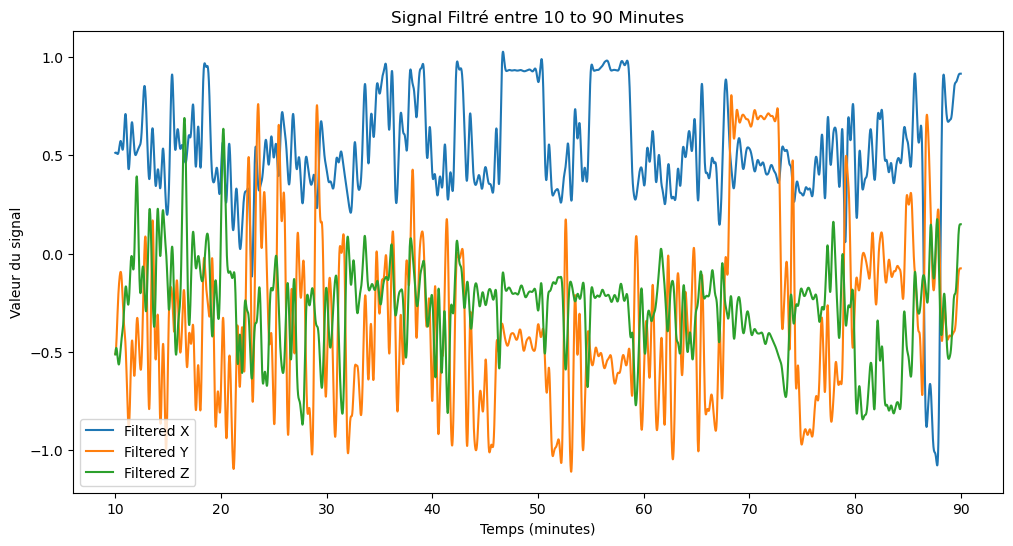

In [23]:
# Define sampling frequency (fs) and cutoff frequency
fs = 1 / (sampling_interval / 60)  # Sampling frequency in Hz (based on time in minutes)
cutoff = 2  # Low-pass filter cutoff frequency in Hz

# Apply the filter to each signal column
filtered_signals = {}
for signal in signal_columns:
    filtered_signals[signal] = lowpass_filter(filtered_data[signal], cutoff, fs)

# Convert filtered signals back to a DataFrame for easy plotting
filtered_data_df = pd.DataFrame(filtered_signals)
filtered_data_df['relative_time_minutes'] = filtered_data['relative_time_minutes'].values

# Plot the low-pass filtered signals
plt.figure(figsize=(12, 6))
for signal in signal_columns:
    plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df[signal], label=f"Filtered {signal}")

plt.title("Signal Filtré entre 10 to 90 Minutes")
plt.xlabel("Temps (minutes)")
plt.ylabel("Valeur du signal")
plt.legend()
plt.show()

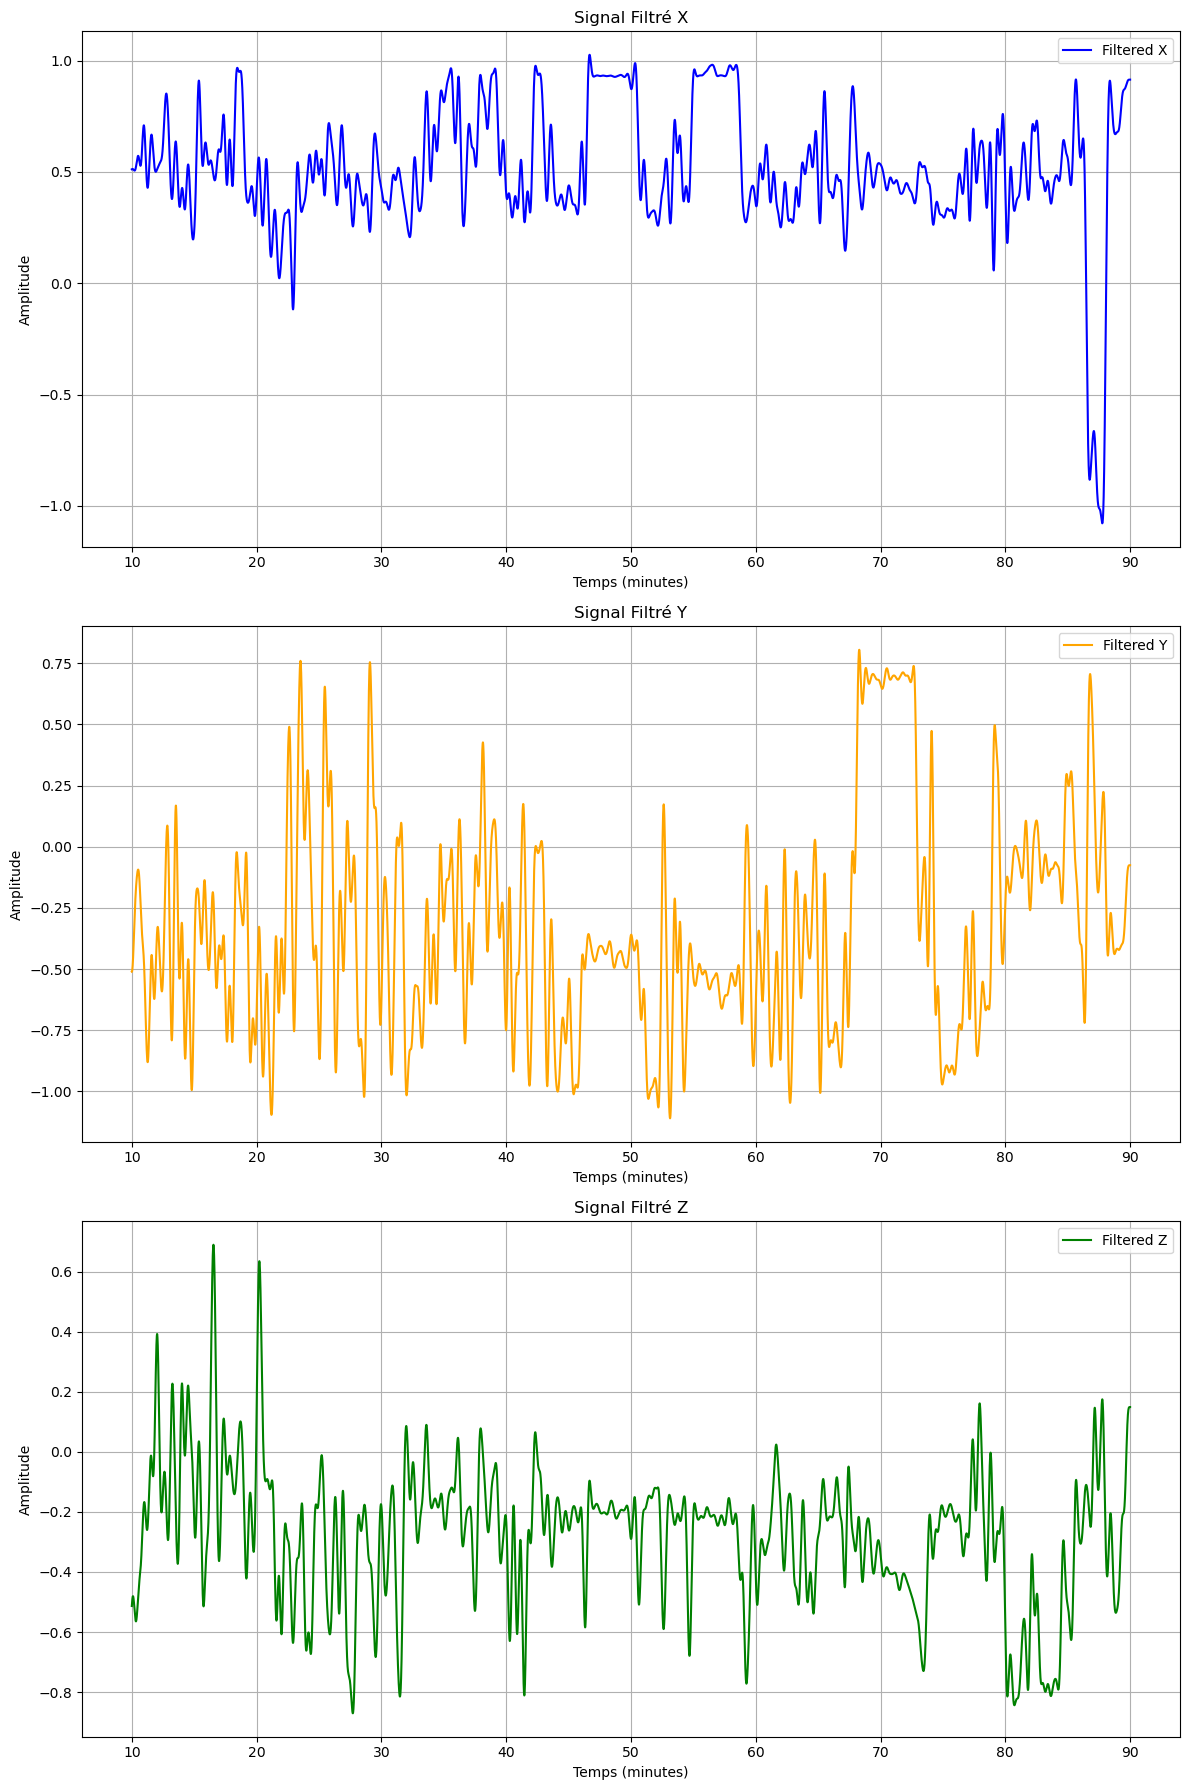

In [25]:
# Afficher les signaux filtrés X, Y et Z sur des graphiques séparés
plt.figure(figsize=(12, 18))

# Axe X
plt.subplot(3, 1, 1)
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df['X'], label='Filtered X', color='blue')
plt.title('Signal Filtré X')
plt.xlabel('Temps (minutes)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Axe Y
plt.subplot(3, 1, 2)
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df['Y'], label='Filtered Y', color='orange')
plt.title('Signal Filtré Y')
plt.xlabel('Temps (minutes)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Axe Z
plt.subplot(3, 1, 3)
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df['Z'], label='Filtered Z', color='green')
plt.title('Signal Filtré Z')
plt.xlabel('Temps (minutes)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


## IV) Calcule des métriques et corrélation

In [28]:
# Recalculer les métriques des axes (X, Y, Z) sans dépendre de SciPy
import pandas as pd

def calculate_basic_metrics(signal):
    # Nombre de pics détectés manuellement : simple dérivée pour détection de variations significatives
    peaks = (signal[1:-1] > signal[:-2]) & (signal[1:-1] > signal[2:])
    num_peaks = peaks.sum()
    
    # Intensité moyenne (amplitude)
    mean_amplitude = signal.max() - signal.min() if len(signal) > 0 else 0
    
    return num_peaks, mean_amplitude

# Calcul des métriques pour chaque axe
metrics = {}
for axis in ['X', 'Y', 'Z']:
    signal = data[axis].values
    num_peaks, mean_amplitude = calculate_basic_metrics(signal)
    metrics[axis] = {
        'Nombre de pics': num_peaks,
        'Amplitude moyenne': mean_amplitude,
    }

# Calculer la corrélation entre les axes X, Y et Z
correlations = data[['X', 'Y', 'Z']].corr()

# Présenter les résultats des métriques et des corrélations
metrics_df = pd.DataFrame(metrics).T
print("Métriques des Axes (X, Y, Z):\n", metrics_df)
print("\nCorrélations entre les Axes (X, Y, Z):\n", correlations)


Métriques des Axes (X, Y, Z):
    Nombre de pics  Amplitude moyenne
X        150385.0          15.984375
Y        164599.0          15.984375
Z        202530.0          10.703125

Corrélations entre les Axes (X, Y, Z):
           X         Y         Z
X  1.000000 -0.257405 -0.165001
Y -0.257405  1.000000 -0.136309
Z -0.165001 -0.136309  1.000000


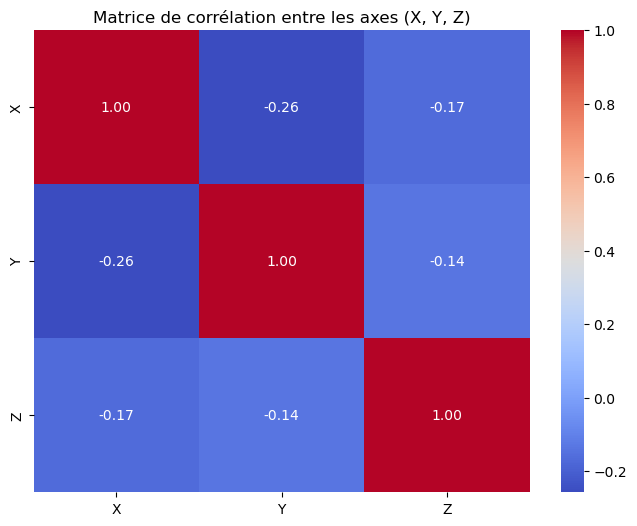

In [29]:
# Calculer la corrélation entre les axes X, Y et Z
correlations = data[['X', 'Y', 'Z']].corr()

# Afficher la matrice de corrélation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matrice de corrélation entre les axes (X, Y, Z)")
plt.show()


L'axe Z présente plus de pics que l'axe X et Y, quasiment 1/4 de pics supplémentaires, ce qui indique que l'activité mesurée présente plus de variations rapides sur l'axe Z, comme une oscillation ou une activité périodique. 
Cependant l'amplitude moyenne est plus faible sur l'axe Z. Les variations sur l'axe Z sont donc plus fréquentes mais de moins grosse intensité. 

En course, ces pics représentent les oscillations du corps dans différentes directions :

  - X :  Mouvement latéral (oscillations gauche-droite des bras ou des hanches).
  - Y : Mouvement vers l'avant ou l'arrière (propulsion ou oscillations en raison du pas de course).
- Z : Reflète les variations verticales (montées et descentes dues aux foulées).
Le fait que Z ait le plus grand nombre de pics montre que le mouvement vertical (les rebonds des foulées) est le plus rapide et le plus fréquent.


Les amplitudes similaires pour X et Y suggèrent que les mouvements latéraux (bras) et avant-arrière (propulsion) sont d'une intensité comparable.
L'amplitude plus faible sur Z est logique, car les oscillations verticales lors de la course sont généralement contrôlées (les rebonds sont amortis pour économiser de l'énergie et rester efficace).

L'axe Z montre une très faible corrélation négative avec X et Y, relevant des variations sur Z indépente de la variation de X et Y, d'ou le nombre de pics élévés sur Z. 
La corrélation entre X et Y reste modérément négative (-0.257), suggérant une légère opposition dans les variations entre ces deux axes.

#### *Corrélation faible entre Z et les autres axes :*
Cela montre que les variations verticales (Z) sont relativement indépendantes des mouvements latéraux (X) et avant-arrière (Y). Pendant la course, cela est attendu, car les rebonds (Z) suivent un rythme constant lié aux foulées, tandis que les bras et la propulsion peuvent varier.


La course implique un mouvement rythmique vertical dominant, comme le montrent le nombre élevé de pics et la cadence de l'axe Z. Cela reflète les cycles réguliers des foulées.

## V) ENMO 

                    Temps         X         Y         Z  Temps écoulé (s)  \
0 2024-10-06 15:39:03.100  0.234375 -0.703125  0.093750             0.000   
1 2024-10-06 15:39:03.102  0.281250 -0.765625  0.093750             0.002   
2 2024-10-06 15:39:03.105  0.281250 -0.765625  0.109375             0.003   
3 2024-10-06 15:39:03.107  0.234375 -0.781250  0.109375             0.002   
4 2024-10-06 15:39:03.110  0.234375 -0.781250  0.093750             0.003   

   Temps cumulé (s)  relative_time_minutes      norm  ENMO  
0             0.000               0.000000  0.747065   0.0  
1             0.002               0.000033  0.821019   0.0  
2             0.005               0.000067  0.822950   0.0  
3             0.007               0.000100  0.822950   0.0  
4             0.010               0.000133  0.821019   0.0  


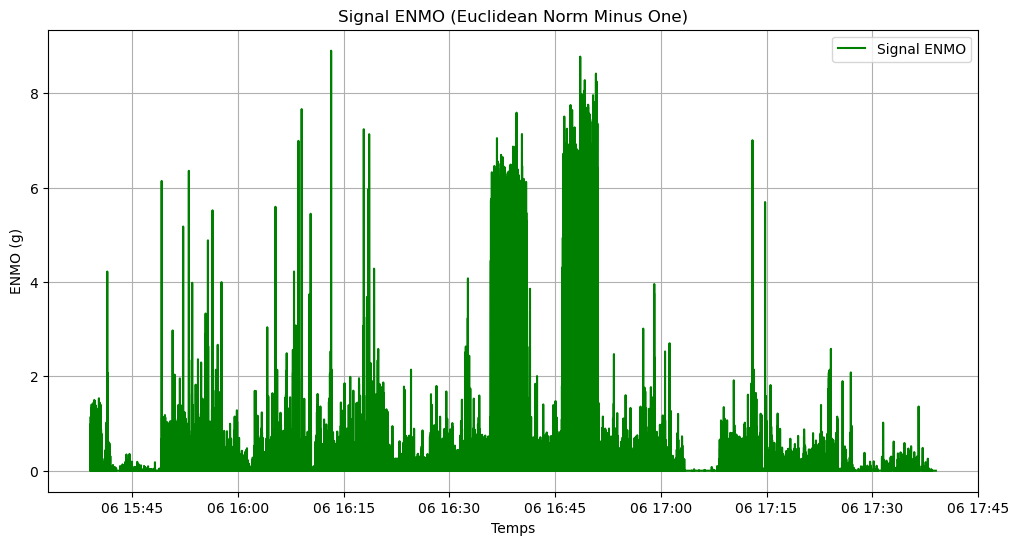

In [30]:


# Calcul de la norme euclidienne pour chaque point
data['norm'] = np.sqrt(data['X']**2 + data['Y']**2 + data['Z']**2)

# Calcul de l'ENMO : norme - 1, avec un minimum de 0
data['ENMO'] = np.maximum(data['norm'] - 1, 0)

# Afficher les premières lignes pour vérifier
print(data.head())

# Visualisation du signal ENMO
plt.figure(figsize=(12, 6))
plt.plot(data['Temps'], data['ENMO'], label='Signal ENMO', color='green')
plt.title('Signal ENMO (Euclidean Norm Minus One)')
plt.xlabel('Temps')
plt.ylabel('ENMO (g)')
plt.legend()
plt.grid()
plt.show()


In [1]:
# Statistiques de base
stats = filtered_data['ENMO'].describe()
print(stats)

NameError: name 'filtered_data' is not defined

# B. Phase 2 : Analyse comparative 

In [12]:
#[COM] Utilisation Pratique

Nombre total de pics détectés : 17
Intervalle moyen entre les pics : 4.12 minutes
Cadence moyenne : 0.79 pas par minute


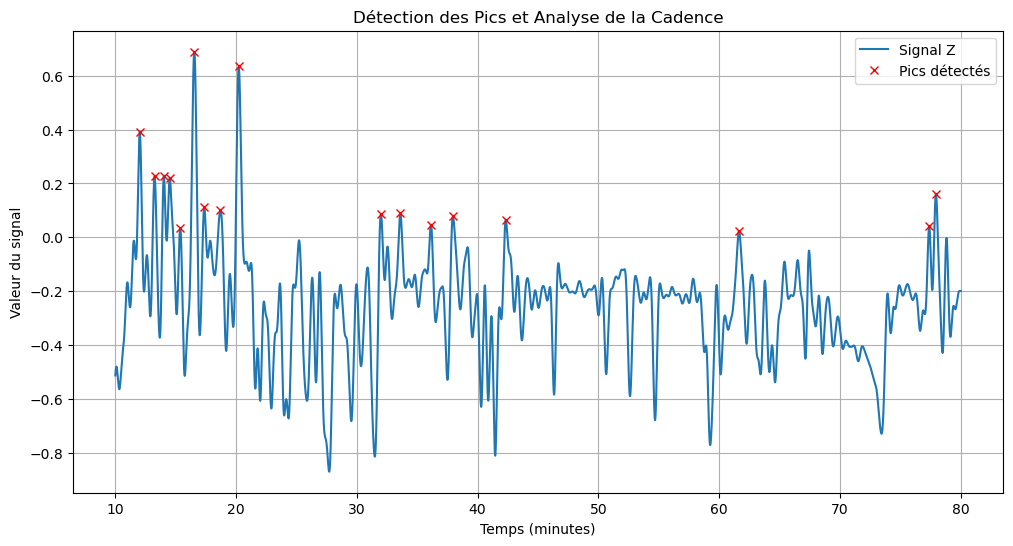

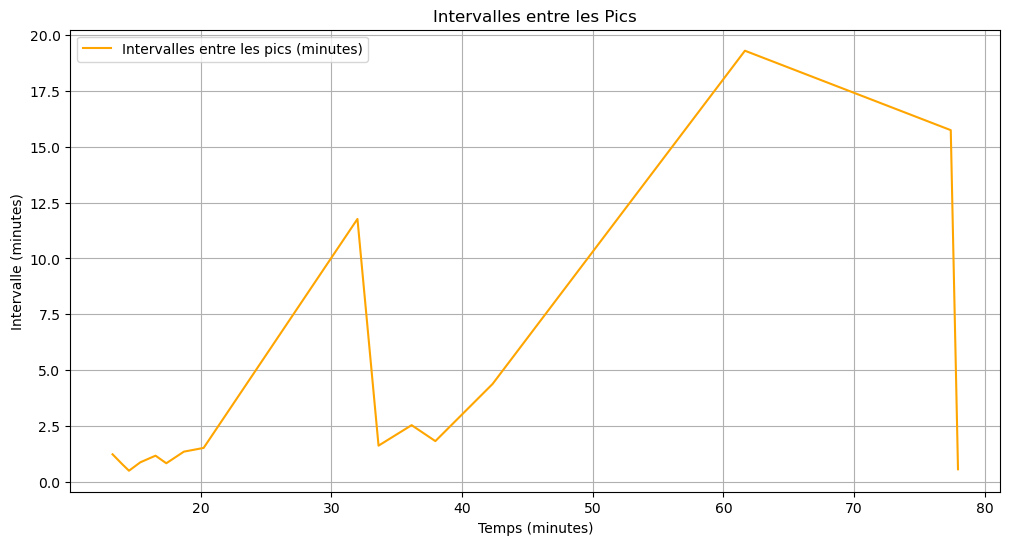

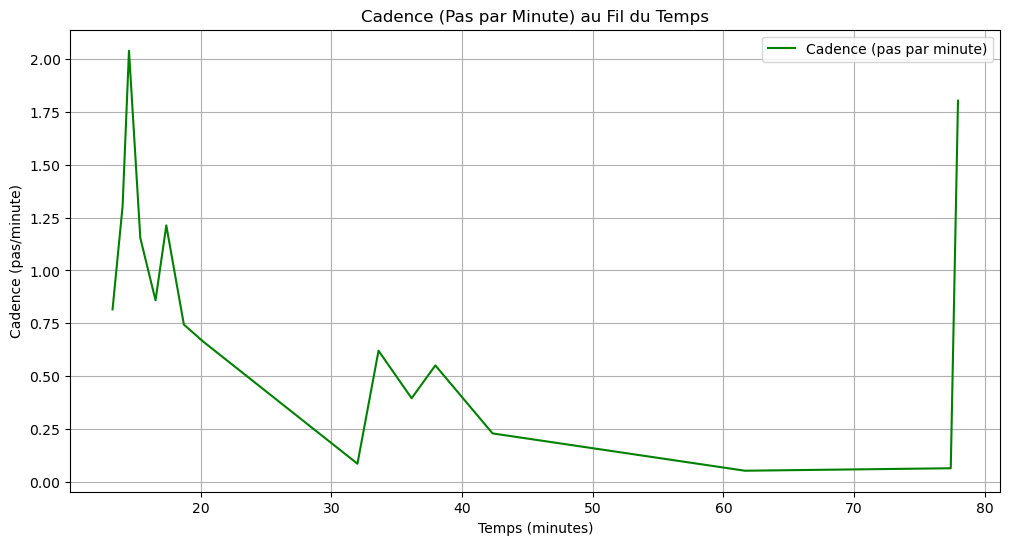

In [13]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Sélectionnez l'axe pertinent (par exemple, axe Z)
signal_column = signal_columns[2]  # Supposons que l'axe Z est la troisième colonne

# Détectez les pics dans le signal filtré
peaks, _ = find_peaks(filtered_data_df[signal_column], height=0)  # Ajustez 'height' si nécessaire

# Calculez les temps associés aux pics détectés
peak_times = filtered_data_df['relative_time_minutes'].iloc[peaks]

# Calculez les intervalles entre les pics (en minutes)
intervals = peak_times.diff().dropna()

# Convertissez les intervalles en cadence (pas par minute)
cadence = 1 / intervals  # En pas par minute

# Affichez les statistiques
print(f"Nombre total de pics détectés : {len(peaks)}")
print(f"Intervalle moyen entre les pics : {intervals.mean():.2f} minutes")
print(f"Cadence moyenne : {cadence.mean():.2f} pas par minute")

# Visualisez le signal et les pics détectés
plt.figure(figsize=(12, 6))
plt.plot(filtered_data_df['relative_time_minutes'], filtered_data_df[signal_column], label="Signal Z")
plt.plot(peak_times, filtered_data_df[signal_column].iloc[peaks], "x", label="Pics détectés", color='red')
plt.title("Détection des Pics et Analyse de la Cadence")
plt.xlabel("Temps (minutes)")
plt.ylabel("Valeur du signal")
plt.legend()
plt.grid(True)
plt.show()

# Visualisez les intervalles entre les pics
plt.figure(figsize=(12, 6))
plt.plot(peak_times.iloc[1:], intervals, label="Intervalles entre les pics (minutes)", color='orange')
plt.title("Intervalles entre les Pics")
plt.xlabel("Temps (minutes)")
plt.ylabel("Intervalle (minutes)")
plt.legend()
plt.grid(True)
plt.show()

# Visualisez la cadence
plt.figure(figsize=(12, 6))
plt.plot(peak_times.iloc[1:], cadence, label="Cadence (pas par minute)", color='green')
plt.title("Cadence (Pas par Minute) au Fil du Temps")
plt.xlabel("Temps (minutes)")
plt.ylabel("Cadence (pas/minute)")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#Analyse des Graphiques